In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check

In [2]:
def decentralizedSGD(x0, lr, max_iter, W, oracle):
    
    x_t = x0
    
    x_store = np.zeros((max_iter, x0.shape[0], x0.shape[1]))
    
    for t in range(max_iter):
         
        noise = np.random.normal(0, 1, size=x_t.shape)
        
        f, df = oracle(x_t + noise)
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        x_store[t, :, :] = x_t
        
    return x_store

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = min(1 / (degrees[i] + 1), 1 / (degrees[j] + 1))
                
                W[i, j] = weight
                W[j, i] = weight
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            W[i, i] = 0
            
        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [0]
            else:
                connections[node] = [node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        for node in range(1, n_nodes):
            connections[node] = [0] # node 0 is central node
            
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(n_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, plot=True):
    
    x0 = np.random.randn(n_params, n_nodes)
    W = buildTopology(n_nodes, topology)
    oracle = Oracle(func_type, n_params, n_nodes)
    
    x_store = decentralizedSGD(x0, lr, max_iter, W, oracle)
    
    x_star = oracle.getMin()
    f_star, _ = oracle(x_star)
    
    mu = -1 if (func_type != "strongly convex") else 1
    
    errors = accuracy_check(func_type, x_store, oracle, x_star, f_star, mu, W, plot)
    
    iter_below_thresh = [iter_ for iter_, error in enumerate(errors) if error < error_threshold]
    
    if len(iter_below_thresh) > 0:
        print("Converged within {} in {} iterations.".format(error_threshold, iter_below_thresh[0]))
        
        return iter_below_thresh[0]
    else:
        print("Didn't converge below threshold in {} iterations".format(max_iter))
        
        return -1
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

Starting experiment on 2 nodes.
Converged within 0.0001 in 8 iterations.

Starting experiment on 3 nodes.
Converged within 0.0001 in 10 iterations.

Starting experiment on 10 nodes.
Converged within 0.0001 in 11 iterations.

Starting experiment on 50 nodes.
Converged within 0.0001 in 11 iterations.

Starting experiment on 100 nodes.
Converged within 0.0001 in 12 iterations.



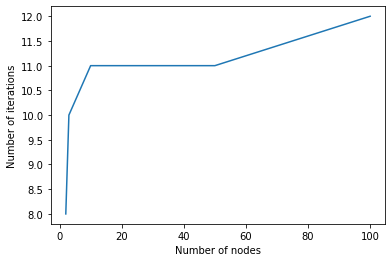

In [4]:
n_params = 10
topology = "ring"
func_type = "strongly convex"
max_iter = 200
lr = 1e-4
threshold = 0.0001

num_nodes = [2, 3, 10, 50, 100]
results = []

for n_nodes in num_nodes:
    print("Starting experiment on {} nodes.".format(n_nodes))
    results.append(experiment(n_nodes, n_params, topology, func_type, max_iter, lr, threshold, False))
    print()
    
plotIter(num_nodes, results)